### Grading
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. <br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** 

### Validate Button
This week's lab doesn't have any auto-graded components. Each question in this notebook has an accompanying Peer Review question. Although the lab shows as being ungraded, you need to complete the notebook to answer the Peer Review questions. 

You do not need to use the Validate button for this lab since there are no auto-graded components. If you hit the Validate button, it will time out given the number of visualizations in the notebook. Cells with longer execution times cause the validate button to time out and freeze. ***This notebook's Validate button time-out does not affect the final submission grading.*** 

# Homework 2. Stochastic Gradient Descent
***

In this assignment we'll implement a rudimentary Stochastic Gradient Descent algorithm to learn the weights in simple linear regression.  Then we'll see if we can make it more efficient.  Finally, we'll investigate some graphical strategies for diagnosing convergence and tuning parameters. 

**Note**: The cell below has some helper functions.  Scroll down and evaluate those before proceeding. 


In [1]:
import numpy as np 
import matplotlib.pylab as plt 
%matplotlib inline

mycolors = {"blue": "steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke": "#f2f2f2"}

def eval_RSS(X, y, b0, b1):
    rss = 0 
    for ii in range(len(df)):
        xi = df.loc[ii, "x"]
        yi = df.loc[ii, "y"]
        rss += (yi - (b0 + b1 * xi)) ** 2
    return rss

def plotsurface(X, y, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1]) ** 2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0, y1], color="black", marker="o", lw=1.5, markersize=5)

### Part 1: Setting Up Simulated Data and a Sanity Check 
***

We'll work with simulated data for this exercise where our generative model is given by 

$$
Y = 1 + 2X + \epsilon \textrm{ where} \epsilon \sim N(0, \sigma^2)
$$

**Part A**: The following function will generate data from the model. We'll grab a training set of size $n=100$ and a validation set of size $n = 50$.  

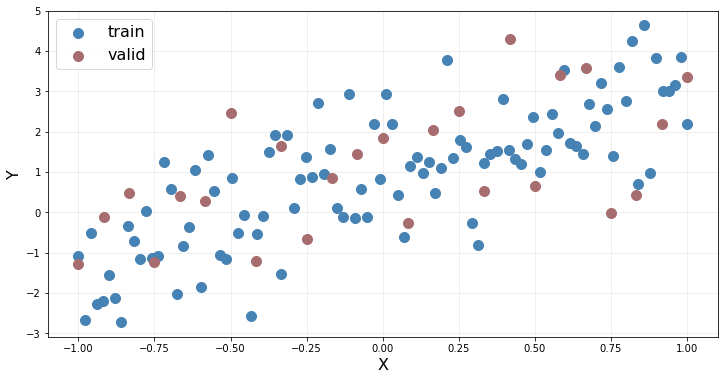

In [2]:
def dataGenerator(n, sigsq=1.0, random_state=1236):
    np.random.seed(random_state)
    x_train = np.linspace(-1, 1, n)
    x_valid = np.linspace(-1, 1, int(n / 4))
    y_train = 1 + 2 * x_train + np.random.randn(n)
    y_valid = 1 + 2 * x_valid + np.random.randn(int(n / 4))
    return x_train, x_valid, y_train, y_valid 

x_train, x_valid, y_train, y_valid = dataGenerator(100)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(x_train, y_train, color="steelblue", s=100, label="train")
ax.scatter(x_valid, y_valid, color="#a76c6e", s=100, label="valid")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.legend(loc="upper left", fontsize=16);

**Part B**: Since we're going to be implementing things ourselves, we're going to want to prepend the data matrices with a column of ones so we can fit a bias term.  We can do this using numpy's [column_stack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.column_stack.html) function. 

In [3]:
X_train = np.column_stack((np.ones_like(x_train), x_train))
X_valid = np.column_stack((np.ones_like(x_valid), x_valid))

In [4]:
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_valid.shape)

Shape of training set:  (100, 2)
Shape of validation set:  (25, 2)


**Part C**: Finally, let's fit a linear regression model with sklearn's LinearRegression class and print the coefficients so we know what we're shooting for. 

In [5]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)
print("sklearn says the coefficients are ", reg.coef_)

sklearn says the coefficients are  [0.90918343 2.20093262]


**Part D**: The last thing we'll do is visualize the surface of the RSS, of which we're attempting to find the minimum. Does it looks like the parameters reported by sklearn lie at the bottom of the RSS surface?  

__My Response__  
It does look like coefficients returned by scikit-learn lie at (or very close to) the bottom/minimum of the RSS surface.

The coefficients would certainly fall within the smallest circle that appears in the RSS surface plot.

__** OTHER NOTES **__
* Pretty sure *RSS* stands for *residual sum of squares*
* WIKIPEDIA: "residual sum of squares (RSS), also known as the sum of squared residuals (SSR) or the sum of squared estimate of errors (SSE)..."
* Basically referring to the standard method of calculating loss for ORDINARY LEAST SQUARES regression

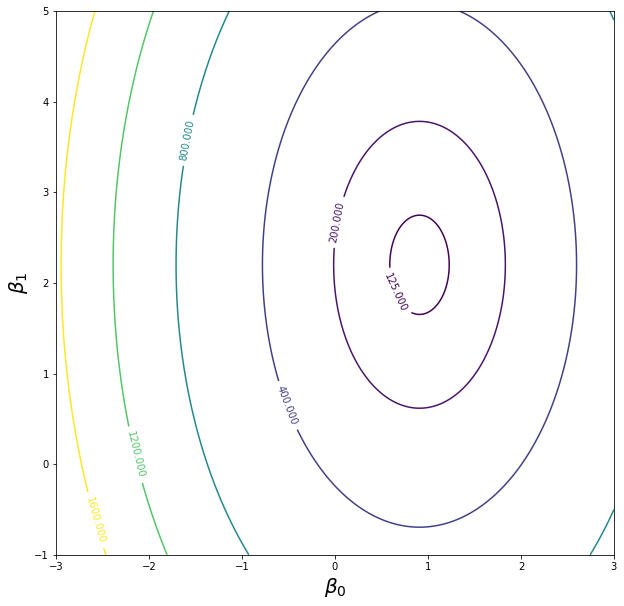

In [6]:
plotsurface(X_train, y_train)

### Part 2: Implementing and Improving SGD 
***


**Part A**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 

$$
\begin{eqnarray}
\beta_0 &\leftarrow& \beta_0 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] \\
\beta_1 &\leftarrow& \beta_1 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] x_i\\
\end{eqnarray}
$$

Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting and diagnostic purposes. <br>
Look at the Peer Review assignment for a question about this section. 

In [7]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices 
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # TODO: loop over training examples, update beta (beta[0] and beta[1]) 
        # your code here
        for i in shuffled_inds:
            # error
            e = np.dot(beta, X[i,:]) - y[i]   # b0 + b1 *x_i - y_i
        
            # updates
            beta[0] = beta[0] - eta * 2 * e
            beta[1] = beta[1] - eta * 2* e * X[i,1]  # the second X[i,:] value should have the non-"ones_like" value
        
        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

CPU times: user 315 ms, sys: 13.8 ms, total: 329 ms
Wall time: 310 ms
beta_0 = 0.90181, beta_1 = 2.19970


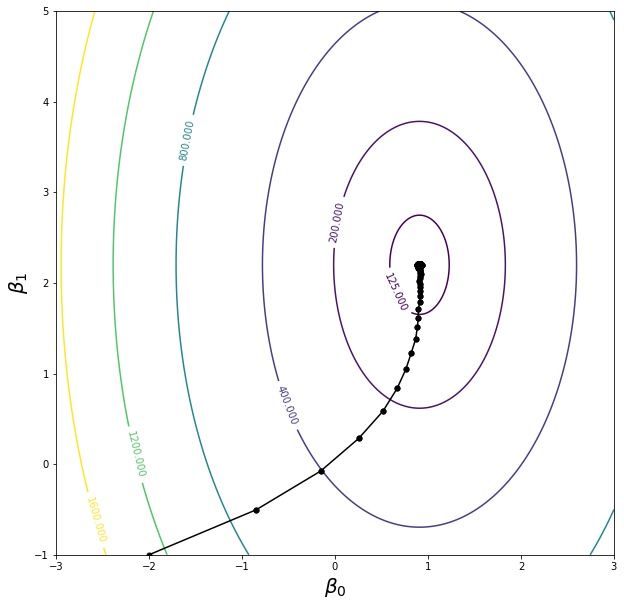

In [8]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000) # old = 0.0025

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part B**: Thinking about the case where we have more than two features, can you think of a way to vectorize the stochastic gradient update of the parameters? When you see it, go back to the sgd function and improve it. 


In [9]:
## TODO: rewrite/modify the sgd function below. Do not modify the previous sgd function, but write a new one here. 
## Do not change the function name.
# your code here
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices 
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # TODO: loop over training examples, update beta (beta[0] and beta[1]) 
        # your code here
        for i in shuffled_inds:
            # error
            e = np.dot(beta, X[i,:]) - y[i]   # b0 + b1 *x_i - y_i
        
            # updates
            beta = beta - 2 * eta * np.dot(X[i,:], e)
        
        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

CPU times: user 572 ms, sys: 1.18 ms, total: 574 ms
Wall time: 573 ms
beta_0 = 0.90668, beta_1 = 2.20111


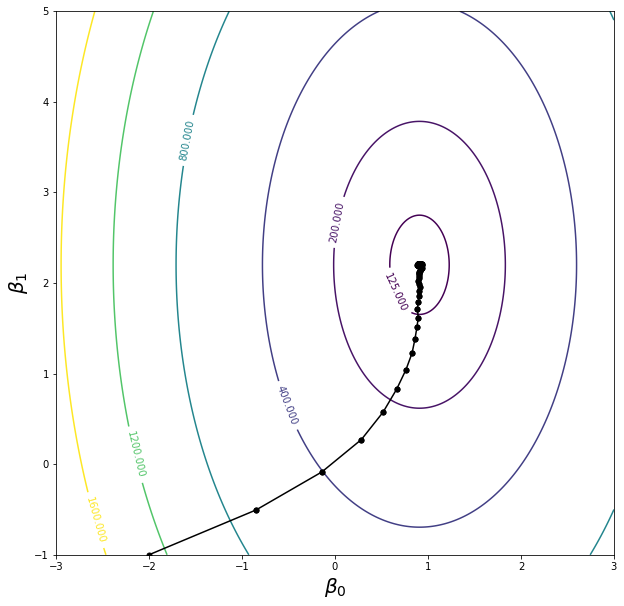

In [10]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part C**: Now that you have created this beautiful solver, go back and break it by playing with the learning rate. Does the learning rate have the effect on convergence that you expect when visualized in the surface plot? 


CPU times: user 610 ms, sys: 878 µs, total: 611 ms
Wall time: 610 ms
beta_0 = nan, beta_1 = nan


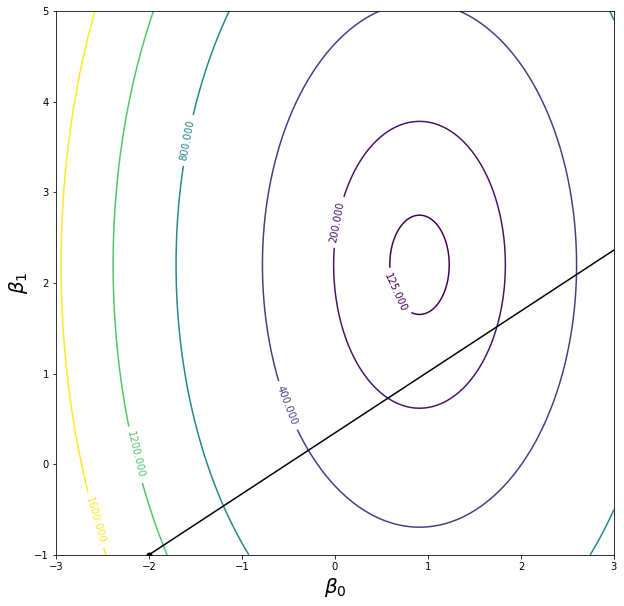

In [11]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training
# your code here

my_eta = 1

%time bhist = sgd(X_train, y_train, beta=beta_start, eta=my_eta, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

CPU times: user 574 ms, sys: 1.08 ms, total: 575 ms
Wall time: 569 ms
beta_0 = 0.99680, beta_1 = 3.66111


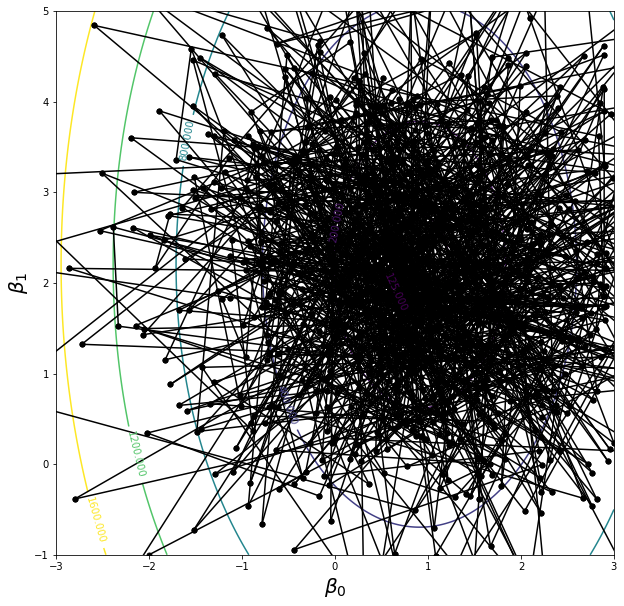

In [12]:
# Start at (-2,1)
# your code here
beta_start = np.array([-2.0, -1.0])

# Training
# your code here

my_eta = 0.5

%time bhist = sgd(X_train, y_train, beta=beta_start, eta=my_eta, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

CPU times: user 566 ms, sys: 20.8 ms, total: 587 ms
Wall time: 575 ms
beta_0 = 1.56379, beta_1 = 2.83014


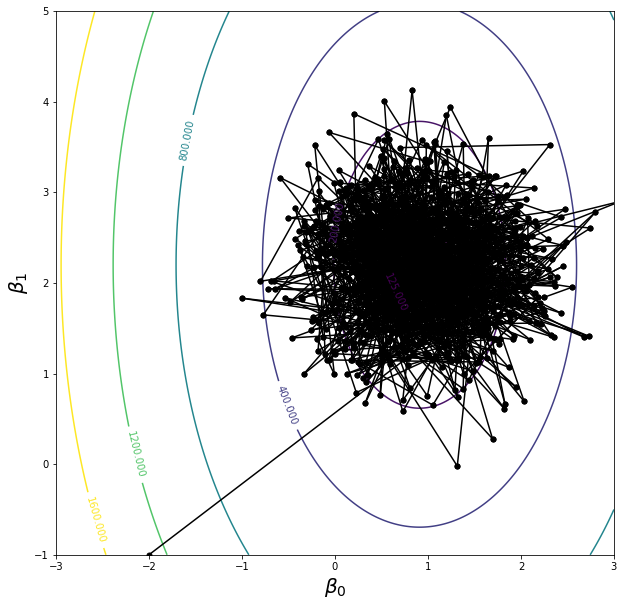

In [13]:
# Start at (-2,1)
# your code here
beta_start = np.array([-2.0, -1.0])

# Training
# your code here

my_eta = 0.25

%time bhist = sgd(X_train, y_train, beta=beta_start, eta=my_eta, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

CPU times: user 607 ms, sys: 4.06 ms, total: 611 ms
Wall time: 606 ms
beta_0 = 1.10143, beta_1 = 2.33812


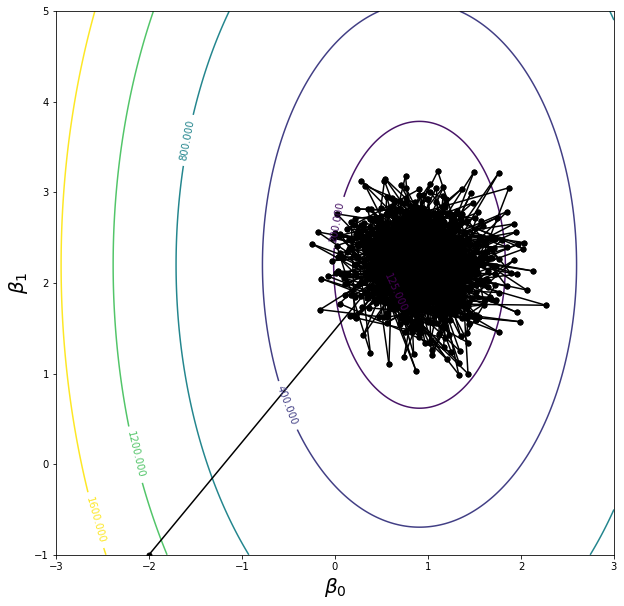

In [14]:
# Start at (-2,1)
# your code here
beta_start = np.array([-2.0, -1.0])

# Training
# your code here

my_eta = 0.125

%time bhist = sgd(X_train, y_train, beta=beta_start, eta=my_eta, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

CPU times: user 573 ms, sys: 20.6 ms, total: 593 ms
Wall time: 578 ms
beta_0 = 1.10910, beta_1 = 2.51836


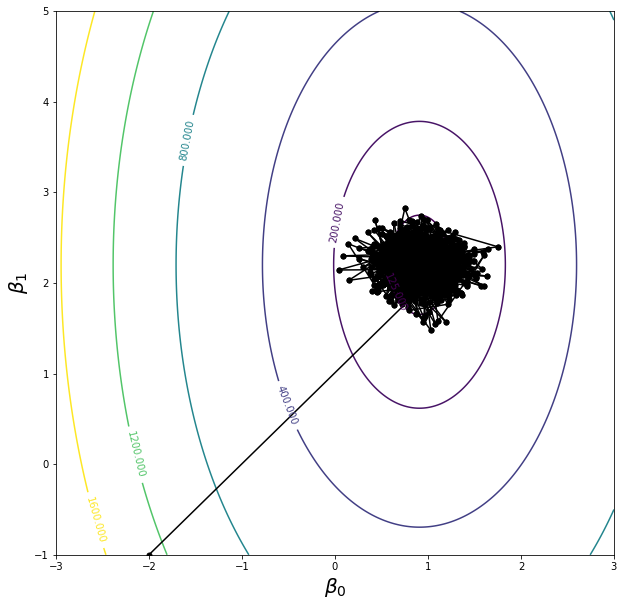

In [15]:
# Start at (-2,1)
# your code here
beta_start = np.array([-2.0, -1.0])

# Training
# your code here

my_eta = 0.06125

%time bhist = sgd(X_train, y_train, beta=beta_start, eta=my_eta, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

### Part 3: Graphical Diagnosis of Convergence 
***

A common way to monitor the convergence of SGD and to tune hyperparameters (like learning rate and regularization strength) is to make a plot of how the loss function evolves during the training process. That is, we plot the value of the loss function periodically and see if it looks like it's reached a minimum, or see if it's jumping around a lot.  Normally we'd record the value of the loss function as we train, but we'll use the beta histories returned by our solver.  Finally, using the MSE instead of the RSS is a popular choice, so we'll do that.  

**Part A**: Modify the function below to take in a beta history and a data set and return a vector of MSE values for each epoch. 

In [30]:
def MSE_hist(X, y, bhist):
    mse = np.zeros(bhist.shape[0])
    
    for epoch in range(bhist.shape[0]):
        # TODO
        # your code here
        squared_errors = (y.reshape(-1,1) - np.matmul(X, bhist[epoch, :].reshape(2,1))) ** 2
        # if epoch == 0:
            # print('Shape of bhist transposed for one epoch: ', bhist[epoch, :].reshape(2,1).shape)
            # print('Shape of X: ', X.shape)
            # print('Shape of y: ', y.shape)
            # print('Shape of "re-shaped" y: ', y.reshape(-1,1).shape)
            # print('Shape of squared errors: ', squared_errors.shape)   
        mse[epoch] = np.mean(squared_errors)  
    return mse 

**Part B**: Next we'll take the MSE history that we just computed and plot it vs epoch number. Based on your plot, would you say that your MSE has converged? 

beta_0 = 0.90727, beta_1 = 2.20077
epochs = 1000 eta = 0.0025

Final MSE:  1.1478860492838818


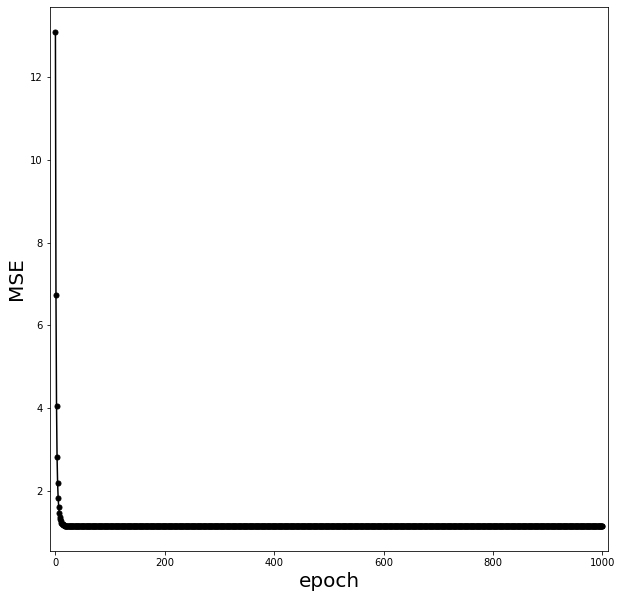

In [31]:
# plot MSE history vs. epoch number 
# your code here

def plot_mse(Xtrain, ytrain, my_eta, my_epochs=1000):
    # PLOT SETUP
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    ax.set_xlim([-10, 1010])
    ax.set_xlabel("epoch", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    # OBTAINING "bhist"
    beta_start = np.array([-2.0, -1.0])  
    bhist = sgd(Xtrain, ytrain, beta=beta_start, eta=my_eta, num_epochs=my_epochs)
    print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
    # CALCULATING AND PLOTTING "MSE_hist"
    y = MSE_hist(X_train, y_train, bhist)
    x = list(range(y.shape[0]))
    ax.plot(x, y, color="black", marker="o", lw=1.5, markersize=5)
    print(f"epochs = {my_epochs:d} eta = {my_eta:0.4f}")
    print("\nFinal MSE: ", y[-1])
    # CHECKING FOR SOURCE OF ERROR
    # print("\n** Looking for Error/Bug **\n")
    # print("Checking 'bhist'...",bhist[10:20,:])
    # print("Checking 'y'...", y[10:20])
    
plot_mse(X_train, y_train, my_eta=0.0025, my_epochs=1000)

Based on the plot above, __the MSE has converged__ by the time the 1000th epoch is reached. In fact, the MSE appears to converge within 100 epochs.

**Part C**: Go back up and change the value of the learning rate to bigger and smaller values (you might also have to adjust the max epochs).  Do the different learning rates have the effect on the MSE plots that you would expect? 

beta_0 = 0.90921, beta_1 = 2.19739
epochs = 1000 eta = 0.0001

Final MSE:  1.1478866271644699


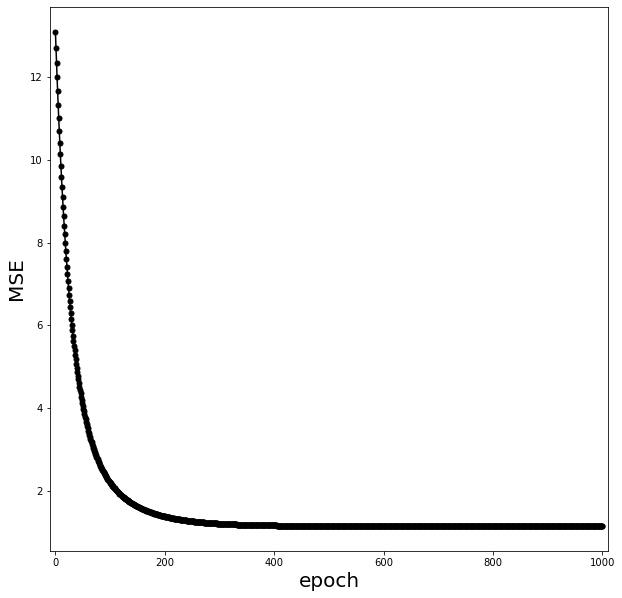

In [33]:
# TODO: change the value of the learning rate to bigger and smaller values, consider adjusting max epochs
# test plots 
# your code here
plot_mse(X_train, y_train, my_eta=0.0001, my_epochs=1000)

beta_0 = 0.72900, beta_1 = 2.64293
epochs = 1000 eta = 0.1000

Final MSE:  1.2467865437883727


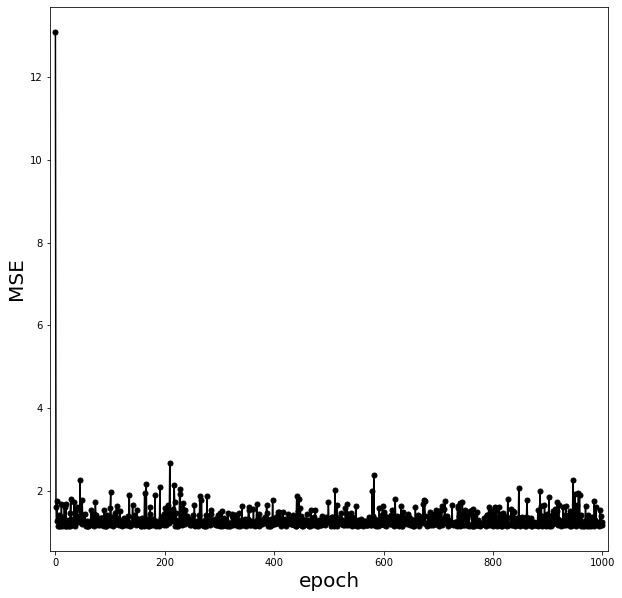

In [34]:
# continue testing plots for C 
# your code here
plot_mse(X_train, y_train, my_eta=0.1, my_epochs=1000)

beta_0 = 1.12265, beta_1 = 2.29243
epochs = 1000 eta = 0.0500

Final MSE:  1.1962994329919834


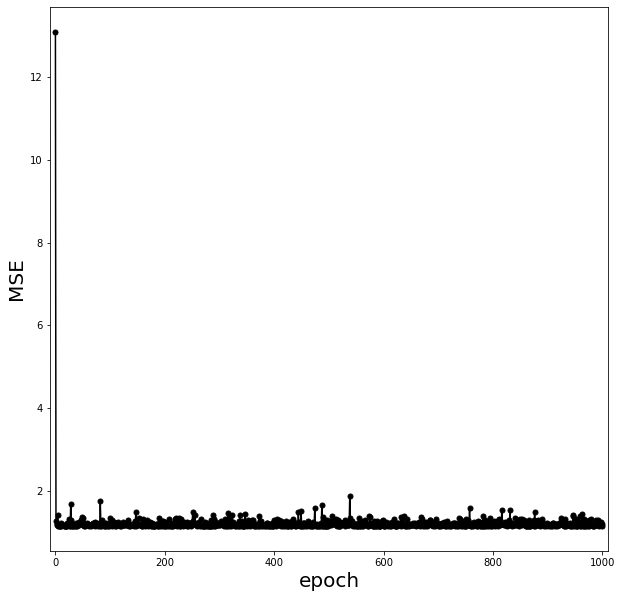

In [35]:
# continue testing plots for C 
# your code here
plot_mse(X_train, y_train, my_eta=0.05, my_epochs=1000)

beta_0 = 0.93024, beta_1 = 2.18836
epochs = 1000 eta = 0.0050

Final MSE:  1.1483797039030237


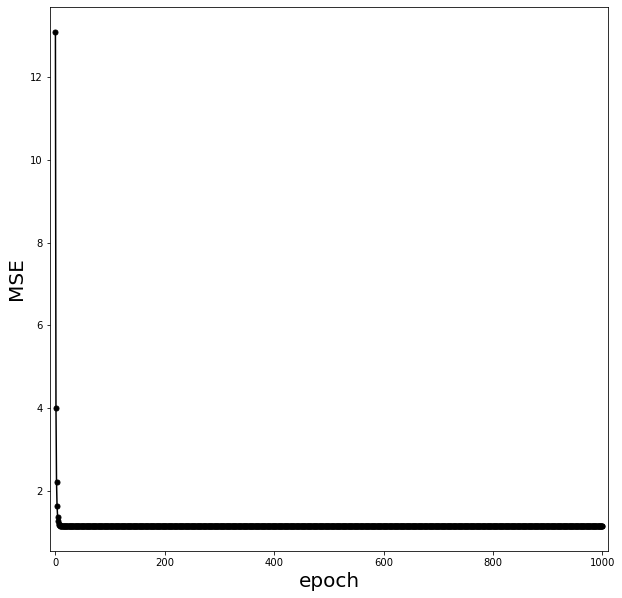

In [36]:
# continue testing plots for C 
# your code here
plot_mse(X_train, y_train, my_eta=0.005, my_epochs=1000)

**Part D**: Is the MSE on the training data the best thing to look at when deciding if our training algorithm has converged? Plot the train and validation MSE as a function of epochs. Discuss the result.

__My Response__

The MSE of the validation data converges at a sligtly higher value than the MSE of the training data. However, with regard to determining when the algorithm converges, both datasets reach consistent MSE values at similar epochs. In this example, we could determine when the training process converges with either the training or validation data MSE. However, I believe it is generally good practice to use the error on the validation dataset for determining when the training process has converged.

It appears that by monitoring the error of the training data the model may overfit the training data since the MSE of the validation data converges at a value that is not the minimum for the dataset.

If training was stopped around epoch 20-40, where the minimum MSE for the validation data occurs, then we may end up with a more general model that is more accurate on the entire dataset and less specific to the training dataset.

beta_0 = 0.90836, beta_1 = 2.20112

MSE for Training Data:  1.1478830559534392

MSE for Validation Data:  1.843464157115401


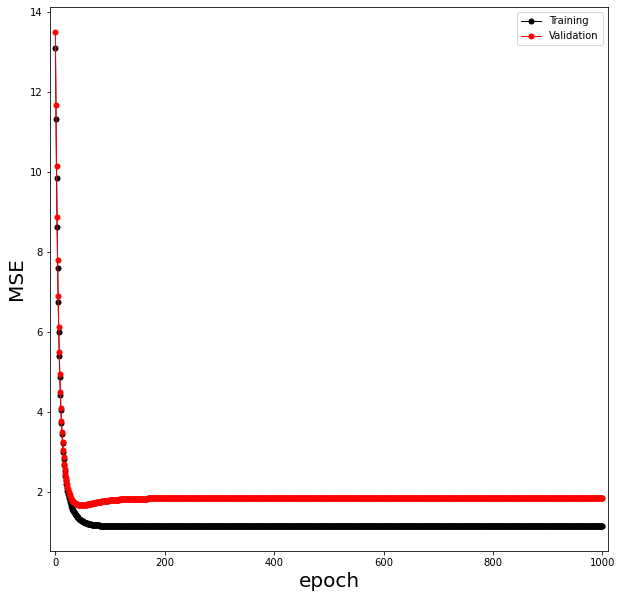

In [42]:
# plot train and validation MSE as function of epochs
# Start at (-2,1)
# your code here

# PLOT SETUP
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.set_xlim([-10, 1010])
ax.set_xlabel("epoch", fontsize=20)
ax.set_ylabel("MSE", fontsize=20)

# OBTAINING "bhist"
beta_start = np.array([-2.0, -1.0])  
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0005, num_epochs=1000)
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))

# CALCULATING AND PLOTTING "MSE_hist"
y1 = MSE_hist(X_train, y_train, bhist)
y2 = MSE_hist(X_valid, y_valid, bhist)

x = list(range(y1.shape[0]))
ax.plot(x, y1, color="black", marker="o", lw=1, markersize=5, label="Training")
ax.plot(x, y2, color="red", marker="o", lw=1, markersize=5, label="Validation")
plt.legend()

print("\nMSE for Training Data: ", y1[-1])
print("\nMSE for Validation Data: ", y2[-1])